# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

In [25]:
"""
2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的
            2.資料集中任意取n筆去訓練(n:自填數) 
            
2025/03/17: 1.修改增加Hdc,N輸入參數
            2.Mdoel修正兩個子迴路接考慮Hdc與N            
            
"""

'\n2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的\n            2.資料集中任意取n筆去訓練(n:自填數) \n            \n2025/03/17: 1.修改增加Hdc,N輸入參數\n            2.Mdoel修正兩個子迴路接考慮Hdc與N            \n            \n'

In [26]:
%reset -f  # 清空所有變數

import gc
gc.collect()  # 強制 Python 回收記憶體


Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  清空所有變數, please run `%reset?` for details


0


### Package


In [27]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

### Hyperparameter Config

In [28]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [ ]:
material = "CH467160"
down_sample_way = "range"
downsample = 128

# 訓練情況況
plot_interval = 300
train_show_sample = 1

# 定義保存模型的路徑
model_save_dir = f"./Model/{down_sample_way}/{downsample}/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑
model_save_path = os.path.join(model_save_dir,
                               f"{material}_n_init2.pt")  # 定義模型保存檔名

figure_save_base_path = f"./figure/{down_sample_way}/{downsample}/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [30]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Pcv,
                   n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_N : np.array
        Turns data.
    data_Hdc : np.array
        DC Magnetic field strength data.
    data_H : np.array
        AC Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
        train_loader, valid_loader : DataLoader
        Dataloaders for training, validation
        norm
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = downsample
    cols = range(
        0, 8192, int(8192 / seq_length)
    )  #range(start, stop, step) #*  Add  Down-sample: 8192 to 128 points (Date:241213)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # data_B = data_B - np.mean(data_B, axis=1,
    #                           keepdims=True)  #*  移除降階影響 (Date:250325)
    # data_H = data_H - np.mean(data_H, axis=1, keepdims=True)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack(
        (data_H, data_H[:, :n_init]))  #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 原本在6. 因要先計算標準化故移至這
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    # # 4. Compute normalization parameters (均值 & 標準差)**
    # norm = [
    #     [torch.mean(B).item(), torch.std(B).item()],  # B
    #     [torch.mean(H).item(), torch.std(H).item()],  # H
    #     [torch.mean(F).item(), torch.std(F).item()],  # F
    #     [torch.mean(T).item(), torch.std(T).item()],  # T
    #     [torch.mean(Hdc).item(), torch.std(Hdc).item()],  # Hdc #*(250317新加入)
    #     [torch.mean(N).item(), torch.std(N).item()],  # N #*(250317新加入)
    #     [torch.mean(Pcv).item(), torch.std(Pcv).item()],  # Pv
    # ]

    #  4. Compute normalization parameters (均值 & 標準差)**
    # ! 溫度頻率不變加入微小的 epsilon
    norm = [
        safe_mean_std(B),  # 0: B
        safe_mean_std(H),  # 1: H
        safe_mean_std(F),  # 2: F
        safe_mean_std(T),  # 3: T
        safe_mean_std(dB_dt),  # 4: dB/dt
        safe_mean_std(Pcv),  # 5: Pcv
        safe_mean_std(Hdc),  # 6: Hdc
        safe_mean_std(N)  # 7: N
    ]

    # 用來做test固定標準化參數的
    material_name = f"{material}"
    print(f'"{material_name}": [')
    for param in norm:
        print(f"    {param},")
    print("]")

    # 5. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]  # B
    out_H = (H - norm[1][0]) / norm[1][1]  # H
    in_F = (F - norm[2][0]) / norm[2][1]  # F
    in_T = (T - norm[3][0]) / norm[3][1]  # T

    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]  # Pcv
    in_Hdc = (Hdc - norm[6][0]) / norm[6][1]  # Hdc
    in_N = (N - norm[7][0]) / norm[7][1]  # N

    # 6. Extra features

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 7. Create dataloader to speed up data processing
    full_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Hdc, in_N, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H)

    # Split dataset into train, validation, and test sets (60:20:20)
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size

    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               collate_fn=filter_input)

    return train_loader, valid_loader, norm


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(
        features
    )[:, :4]  #!(250317)保留 in_F, in_T, in_Hdc, in_N (排除 in_Pcv，in_Pcv要放在最面)

    # 保留目標值 H
    target_H = torch.stack(
        target_H)[:, :downsample, :]  # ?只取最後 128 點 (改1024看狀況有無變好)

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


# ! 溫度頻率不變加入微小的 epsilon
def safe_mean_std(tensor, eps=1e-8):
    m_tensor = torch.mean(tensor)  # 還是 Tensor
    s_tensor = torch.std(tensor)  # 還是 Tensor

    m_val = m_tensor.item()  # 第一次轉成 float
    s_val = s_tensor.item()
    if s_val < eps:
        s_val = 1.0

    return [m_val, s_val]  # 直接回傳 float


## Step2: Define Network Structure

In [31]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
# ! - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):
    def __init__(
            self,
            norm,  #*這裡改成從外部傳入 norm(250203)
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=3,
            var_size=4,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = norm  #*這裡改成從外部傳入 norm(250203)

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 4,
                              1)  #!250317更新：operator_size + 4
        self.rnn2 = EddyCell(
            6, self.hidden_size,
            output_size)  #!250317更新：4 (F, T, B, dB/dt ) + 2 (Hdc, N)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
# !       - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N) 
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, :-n_init, :])

        return H


class StopOperatorCell():
    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Step3: Training the Model

### Load Dataset

In [33]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/train/B_Field.csv"
    in_file2 = f"{base_path}{material}/train/Frequency.csv"
    in_file3 = f"{base_path}{material}/train/Temperature.csv"
    in_file4 = f"{base_path}{material}/train/H_Field.csv"
    in_file5 = f"{base_path}{material}/train/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/train/Hdc.csv"  # *250317新增：直流偏置磁場
    in_file7 = f"{base_path}{material}/train/Turns.csv"  # *250317新增：匝數

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024  # *250317新增
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1  # *250317新增
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N


### Train Code

In [ ]:
# %%
def train_model(norm, train_loader, valid_loader):

    model = MMINet(norm=norm).to(device)
    print("Number of parameters: ", count_parameters(model))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # **新增 Loss 記錄**
    train_losses = []
    val_losses = []

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # **記錄 Train Loss**

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # **記錄 Validation Loss**

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )

        # ======================================================繪製訓練情況======================================================

        if (epoch + 1) % plot_interval == 0:

            # 第一次產生固定的隨機索引
            if fixed_idx is None:
                batch_size_fix = 3
                fixed_idx = torch.randperm(batch_size_fix)[:train_show_sample]

            # # -------------------------設定圖表H(t)比較---------------------------------------

            # outputs = [fixed_idx, :downsample,
            #  0].detach().cpu().numpy()
            # targets_np = target_H[fixed_idx, :downsample,
            #                       0].detach().cpu().numpy()

            # plt.figure(figsize=(12, 6))

            # for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
            #     plt.plot(outputs[i, :, 0],
            #              label=f"Pred: Sample {i+1}",
            #              linestyle='--',
            #              marker='o')
            #     plt.plot(targets[i, :, 0],
            #              label=f"Target: Sample {i+1}",
            #              linestyle='-',
            #              marker='x')

            # # 添加標題和標籤
            # plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            # plt.xlabel("Index", fontsize=14)
            # plt.ylabel("Value", fontsize=14)
            # plt.legend(loc="upper right", fontsize=12)
            # plt.grid(alpha=0.5)

            # # 顯示圖表
            # plt.show()
            # # -------------------------設定圖表H(t)比較 結束---------------------------------------

            # # -------------------------設定圖表B-H比較---------------------------------------
            # 取對應 sample
            outputs_np = outputs[fixed_idx, :downsample,
                                 0].detach().cpu().numpy()
            targets_np = target_H[fixed_idx, :downsample,
                                  0].detach().cpu().numpy()
            B_seq_np = inputs[fixed_idx, :downsample, 0].detach().cpu().numpy()

            # 設定圖表
            plt.figure()

            for i in range(train_show_sample):  # 每一批數據繪製一個圖表
                plt.plot(outputs_np[i],
                         B_seq_np[i],
                         label=f"Pred: Sample {i+1}",
                         markersize=1)

                plt.plot(targets_np[i],
                         B_seq_np[i],
                         label=f"Target: Sample {i+1}",
                         alpha=0.5)

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.grid(alpha=0.5)
            plt.legend()
            figure_save_path1 = os.path.join(
                figure_save_base_path,
                f"Compare_Epoch {epoch + 1}.svg")  # 定義模型保存檔名
            plt.savefig(figure_save_path1)
            # 顯示圖表
            plt.show()
            # # -------------------------設定圖表B-H比較 END---------------------------------------
        # ======================================================繪製訓練情況  END ======================================================

        # ======================================================Early stop======================================================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

        # ======================================================Early stop======================================================

    print(f"Training complete. Best model saved at {model_save_path}.")

    # ==============================繪製 Train Loss 與 Validation Loss 圖==============================
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(1,
              len(train_losses) + 1),
        train_losses,
        label="Train Loss",
    )
    plt.plot(range(1,
                   len(val_losses) + 1),
             val_losses,
             label="Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(alpha=0.5)
    figure_save_path2 = os.path.join(figure_save_base_path,
                                     "Training_Loss_Curve.svg")  # 定義模型保存檔名
    plt.savefig(figure_save_path2)
    plt.show()
    # ==============================繪製 Train Loss 與 Validation Loss 圖 END==============================

    # ===================================使用最佳模型來產生驗證結果=============================
    model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型
    model.eval()

    with torch.no_grad():
        for inputs, features, s0, target_H in valid_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            outputs = model(inputs, features, s0)  # 使用最佳模型產生預測值
            break  # 只使用一批驗證數據進行可視化

    # 選取對應資料（index tensor 要先轉 list 才能 index numpy）
    outputs_np = outputs[fixed_idx, :downsample, 0].detach().cpu().numpy()
    targets_np = target_H[fixed_idx, :downsample, 0].detach().cpu().numpy()
    B_seq_np = inputs[fixed_idx, :downsample, 0].detach().cpu().numpy()

    # 設定圖表
    plt.figure()

    for i in range(train_show_sample):  # 每一批數據繪製一個圖表
        plt.plot(outputs_np[i], B_seq_np[i], label=f"Pred: Sample {i+1}")

        plt.plot(targets_np[i],
                 B_seq_np[i],
                 label=f"Target: Sample {i+1}",
                 alpha=0.7)

    # 添加標題和標籤
    plt.title(f"Best Model - Predicted vs Target")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(alpha=0.5)
    plt.legend()
    figure_save_path3 = os.path.join(
        figure_save_base_path,
        "Best Model_Predicted vs Target.svg")  # 定義模型保存檔名
    plt.savefig(figure_save_path3)

    # ===================================使用最佳模型來產生驗證結果 END=============================

### Start Train!!!

"CH467160": [
    [6.006200692354469e-06, 0.029245583340525627],
    [0.13520769774913788, 160.89515686035156],
    [2.0, 1.0],
    [25.0, 1.0],
    [0.00640619033947587, 0.444048672914505],
    [1.8067814111709595, 0.715567409992218],
    [1250.265380859375, 701.6740112304688],
    [12.159845352172852, 3.296860456466675],
]
Number of parameters:  1146
Epoch 1, Train Loss: 1.004040, Validation Loss: 0.909064
Saving model at epoch 1 with validation loss 0.909064...
Epoch 2, Train Loss: 0.848399, Validation Loss: 0.756685
Saving model at epoch 2 with validation loss 0.756685...
Epoch 3, Train Loss: 0.687253, Validation Loss: 0.593352
Saving model at epoch 3 with validation loss 0.593352...
Epoch 4, Train Loss: 0.517161, Validation Loss: 0.401900
Saving model at epoch 4 with validation loss 0.401900...
Epoch 5, Train Loss: 0.309933, Validation Loss: 0.186504
Saving model at epoch 5 with validation loss 0.186504...
Epoch 6, Train Loss: 0.116257, Validation Loss: 0.053786
Saving model at ep

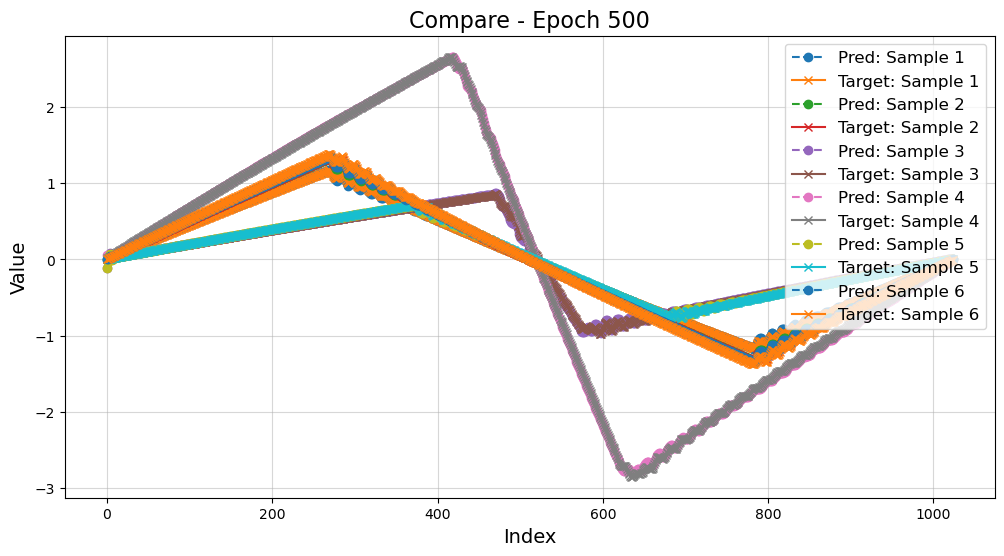

Epoch 501, Train Loss: 0.000249, Validation Loss: 0.000255
Epoch 502, Train Loss: 0.000271, Validation Loss: 0.000247
Epoch 503, Train Loss: 0.000252, Validation Loss: 0.000245
Epoch 504, Train Loss: 0.000257, Validation Loss: 0.000242
Epoch 505, Train Loss: 0.000247, Validation Loss: 0.000239
Saving model at epoch 505 with validation loss 0.000239...
Epoch 506, Train Loss: 0.000249, Validation Loss: 0.000251
Epoch 507, Train Loss: 0.000250, Validation Loss: 0.000257
Epoch 508, Train Loss: 0.000252, Validation Loss: 0.000280
Epoch 509, Train Loss: 0.000257, Validation Loss: 0.000272
Epoch 510, Train Loss: 0.000273, Validation Loss: 0.000249
Epoch 511, Train Loss: 0.000277, Validation Loss: 0.000299
Epoch 512, Train Loss: 0.000290, Validation Loss: 0.000252
Epoch 513, Train Loss: 0.000308, Validation Loss: 0.000265
Epoch 514, Train Loss: 0.000351, Validation Loss: 0.000245
Epoch 515, Train Loss: 0.000293, Validation Loss: 0.000241
Epoch 516, Train Loss: 0.000261, Validation Loss: 0.0002

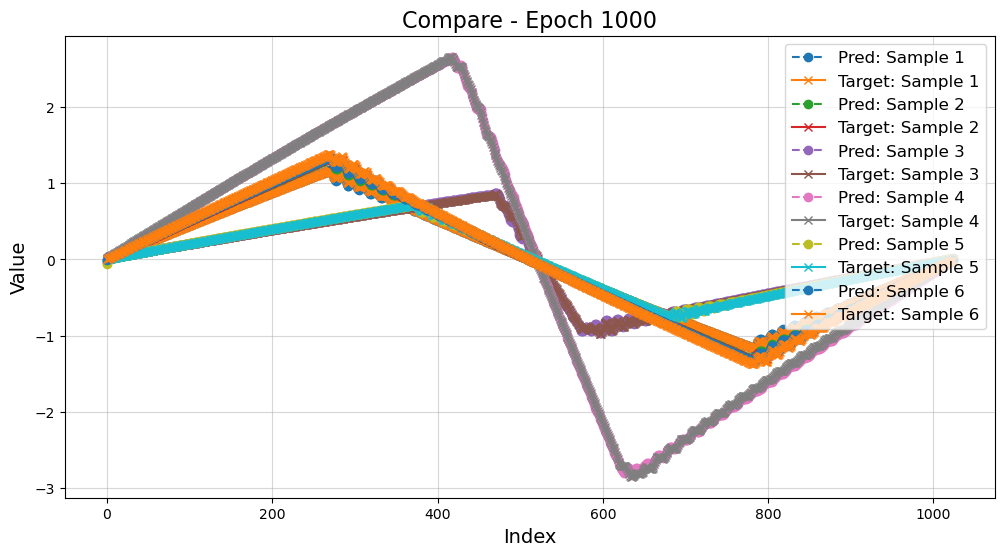

Epoch 1001, Train Loss: 0.000196, Validation Loss: 0.000198
Epoch 1002, Train Loss: 0.000182, Validation Loss: 0.000233
Epoch 1003, Train Loss: 0.000189, Validation Loss: 0.000179
Epoch 1004, Train Loss: 0.000172, Validation Loss: 0.000172
Epoch 1005, Train Loss: 0.000167, Validation Loss: 0.000188
Epoch 1006, Train Loss: 0.000170, Validation Loss: 0.000172
Epoch 1007, Train Loss: 0.000172, Validation Loss: 0.000178
Epoch 1008, Train Loss: 0.000173, Validation Loss: 0.000163
Epoch 1009, Train Loss: 0.000168, Validation Loss: 0.000186
Epoch 1010, Train Loss: 0.000196, Validation Loss: 0.000171
Epoch 1011, Train Loss: 0.000205, Validation Loss: 0.000175
Epoch 1012, Train Loss: 0.000188, Validation Loss: 0.000185
Epoch 1013, Train Loss: 0.000175, Validation Loss: 0.000161
Saving model at epoch 1013 with validation loss 0.000161...
Epoch 1014, Train Loss: 0.000164, Validation Loss: 0.000167
Epoch 1015, Train Loss: 0.000162, Validation Loss: 0.000163
Epoch 1016, Train Loss: 0.000165, Valida

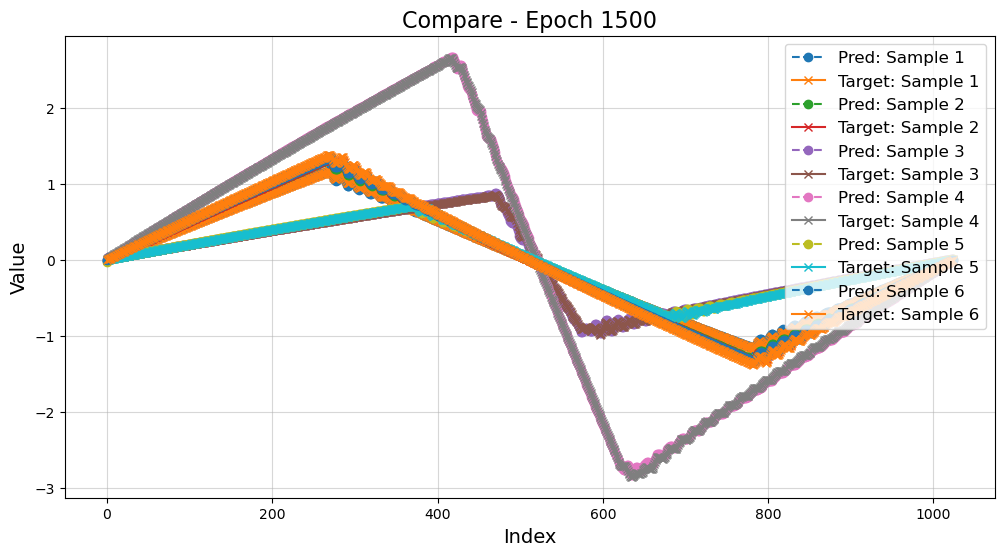

Epoch 1501, Train Loss: 0.000145, Validation Loss: 0.000142
Epoch 1502, Train Loss: 0.000140, Validation Loss: 0.000143
Epoch 1503, Train Loss: 0.000136, Validation Loss: 0.000141
Epoch 1504, Train Loss: 0.000154, Validation Loss: 0.000173
Epoch 1505, Train Loss: 0.000165, Validation Loss: 0.000166
Epoch 1506, Train Loss: 0.000160, Validation Loss: 0.000141
Epoch 1507, Train Loss: 0.000144, Validation Loss: 0.000141
Epoch 1508, Train Loss: 0.000136, Validation Loss: 0.000151
Epoch 1509, Train Loss: 0.000138, Validation Loss: 0.000151
Epoch 1510, Train Loss: 0.000151, Validation Loss: 0.000173
Epoch 1511, Train Loss: 0.000181, Validation Loss: 0.000200
Epoch 1512, Train Loss: 0.000201, Validation Loss: 0.000149
Epoch 1513, Train Loss: 0.000157, Validation Loss: 0.000153
Epoch 1514, Train Loss: 0.000146, Validation Loss: 0.000142
Epoch 1515, Train Loss: 0.000150, Validation Loss: 0.000204
Epoch 1516, Train Loss: 0.000165, Validation Loss: 0.000159
Epoch 1517, Train Loss: 0.000145, Valida

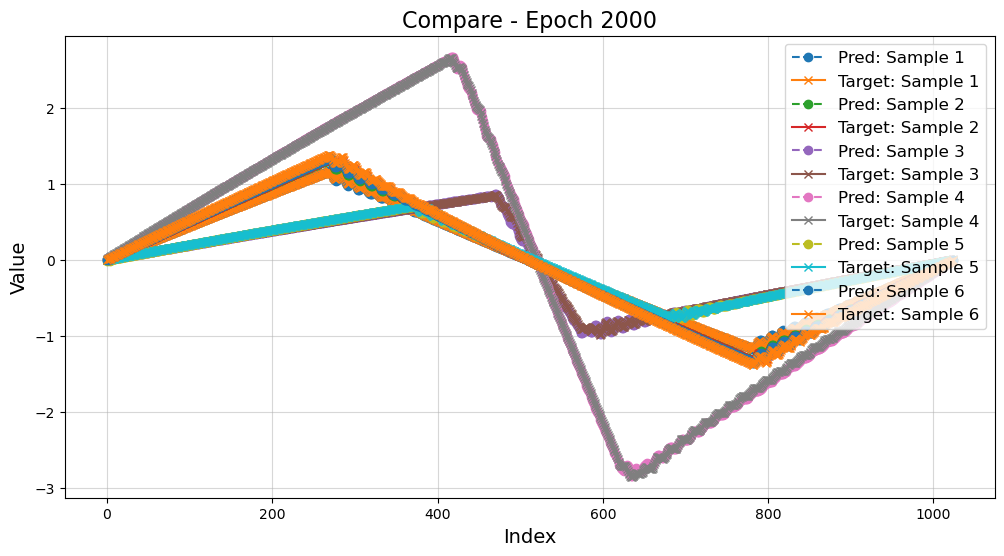

Epoch 2001, Train Loss: 0.000148, Validation Loss: 0.000154
Epoch 2002, Train Loss: 0.000132, Validation Loss: 0.000140
Epoch 2003, Train Loss: 0.000125, Validation Loss: 0.000142
Epoch 2004, Train Loss: 0.000130, Validation Loss: 0.000126
Epoch 2005, Train Loss: 0.000130, Validation Loss: 0.000157
Epoch 2006, Train Loss: 0.000144, Validation Loss: 0.000156
Epoch 2007, Train Loss: 0.000154, Validation Loss: 0.000137
Epoch 2008, Train Loss: 0.000145, Validation Loss: 0.000143
Epoch 2009, Train Loss: 0.000140, Validation Loss: 0.000135
Epoch 2010, Train Loss: 0.000144, Validation Loss: 0.000127
Epoch 2011, Train Loss: 0.000129, Validation Loss: 0.000129
Epoch 2012, Train Loss: 0.000127, Validation Loss: 0.000136
Epoch 2013, Train Loss: 0.000129, Validation Loss: 0.000133
Epoch 2014, Train Loss: 0.000130, Validation Loss: 0.000128
Epoch 2015, Train Loss: 0.000123, Validation Loss: 0.000129
Epoch 2016, Train Loss: 0.000124, Validation Loss: 0.000151
Epoch 2017, Train Loss: 0.000135, Valida

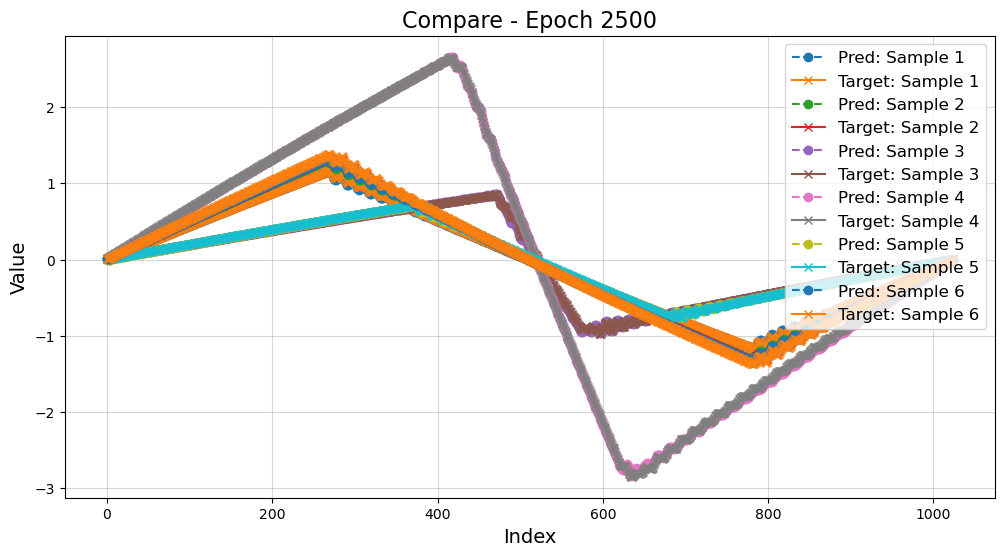

Epoch 2501, Train Loss: 0.000123, Validation Loss: 0.000123
Epoch 2502, Train Loss: 0.000124, Validation Loss: 0.000162
Epoch 2503, Train Loss: 0.000138, Validation Loss: 0.000155
Epoch 2504, Train Loss: 0.000147, Validation Loss: 0.000169
Epoch 2505, Train Loss: 0.000135, Validation Loss: 0.000138
Epoch 2506, Train Loss: 0.000121, Validation Loss: 0.000141
Epoch 2507, Train Loss: 0.000131, Validation Loss: 0.000166
Epoch 2508, Train Loss: 0.000183, Validation Loss: 0.000222
Epoch 2509, Train Loss: 0.000143, Validation Loss: 0.000126
Epoch 2510, Train Loss: 0.000126, Validation Loss: 0.000125
Epoch 2511, Train Loss: 0.000124, Validation Loss: 0.000129
Epoch 2512, Train Loss: 0.000122, Validation Loss: 0.000132
Epoch 2513, Train Loss: 0.000131, Validation Loss: 0.000142
Epoch 2514, Train Loss: 0.000125, Validation Loss: 0.000128
Epoch 2515, Train Loss: 0.000121, Validation Loss: 0.000121
Epoch 2516, Train Loss: 0.000127, Validation Loss: 0.000141
Epoch 2517, Train Loss: 0.000125, Valida

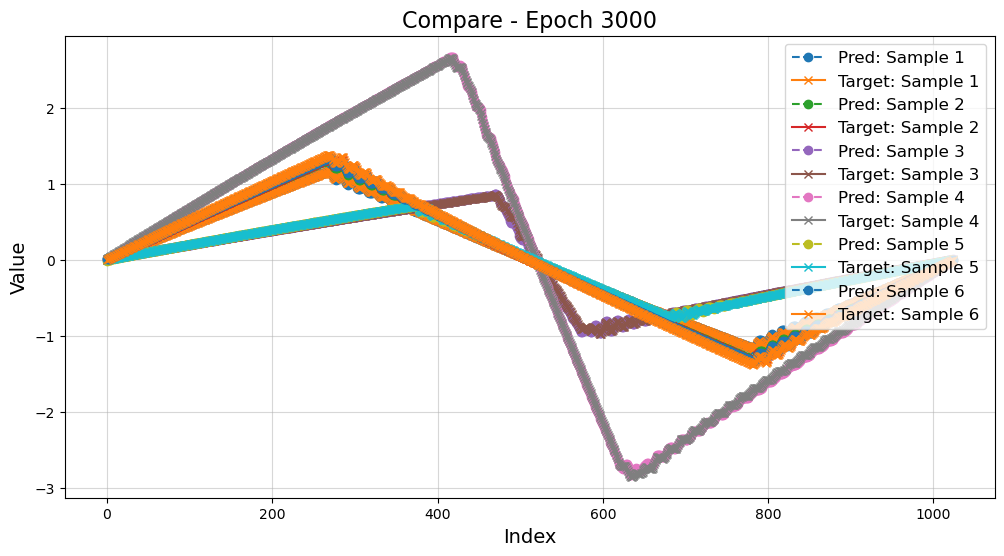

Training complete. Best model saved at ./Model/CH467160_n_init.pt.


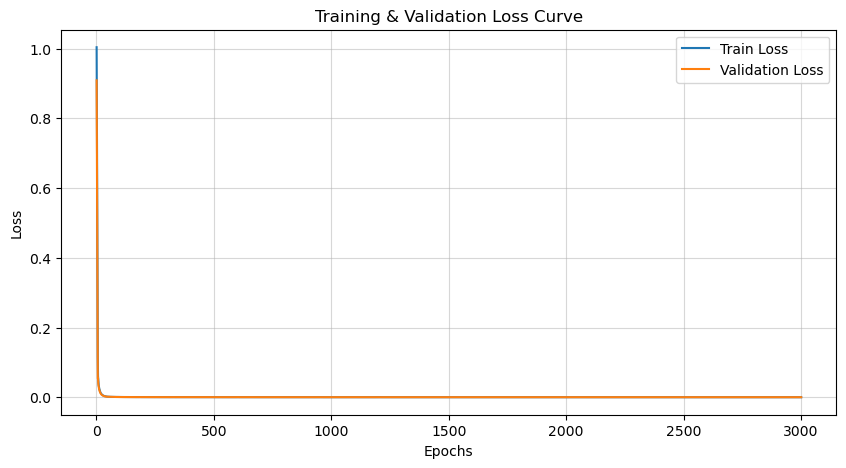

C:\Users\USER\AppData\Local\Temp\ipykernel_39868\2099318306.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # 載入最佳模

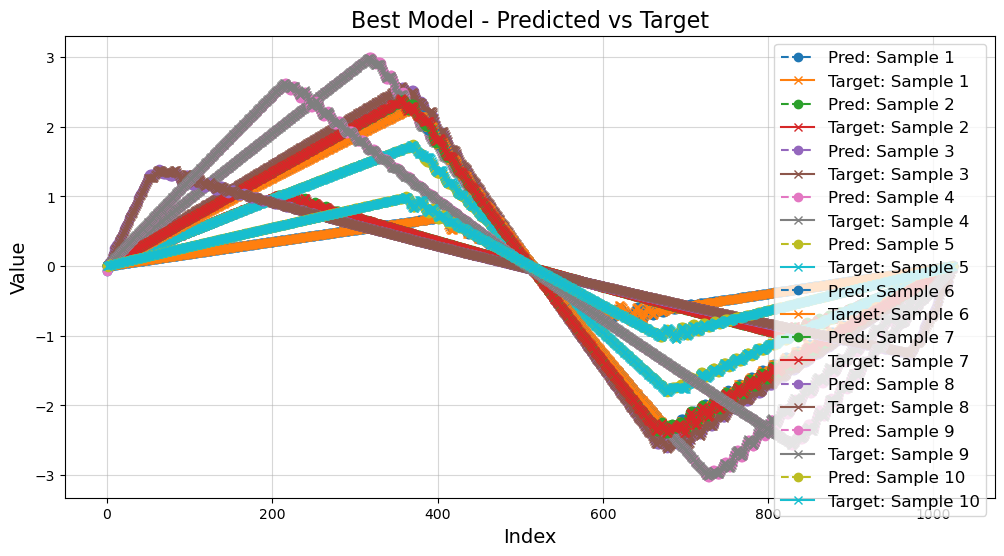

In [36]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N = load_dataset(
        material)

    train_loader, valid_loader, norm = get_dataloader(data_B, data_F, data_T,
                                                      data_H, data_N, data_Hdc,
                                                      data_Pcv)

    train_model(norm, train_loader, valid_loader)